In [1]:
# import libraries
%matplotlib inline
import re
import os 
import pickle
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean 
from time import time
import plotly.graph_objects as go

import nltk 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from textblob import TextBlob, Word
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YZD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YZD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\YZD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
os.chdir(r'C:\Users\YZD\Desktop\NUS\MSBA\Semster 2 - 2020\BT5153 - Applied Machine Learning for Business Analytics\Project\data\kaggle')
df_train = pd.read_csv("train.csv")
# df_test = pd.read_csv("test.csv")
# print('Test dataset : \n', df_test.shape, '\n', df_test.head(5))

## EDA on training dataset  

In [27]:
print('Train dataset : \n', df_train.shape, '\n', df_train.head(5), '\n', df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
Train dataset : 
 (159571, 8) 
                  id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   seve

In [28]:
df_toxic = df_train.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0.5, 0, 'category')

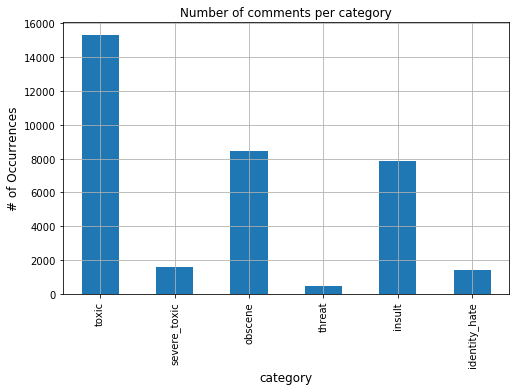

In [29]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

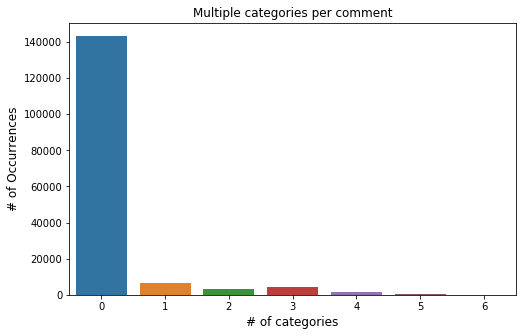

In [30]:
rowsums = df_train.iloc[:,2:].sum(axis=1)
x = rowsums.value_counts()#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [31]:
# Percentage of comments that are not labelled
print(x[0])
print(x[0]/ len(df_train))

143346
0.8983211235124177


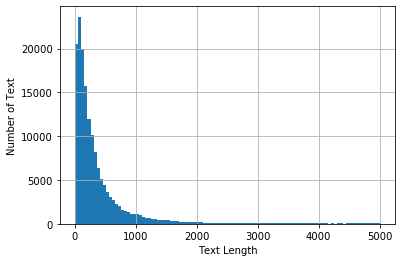

In [32]:
lens = df_train.comment_text.str.len()
lens.hist(bins = 100)
plt.ylabel('Number of Text')
plt.xlabel('Text Length')
plt.show()

In [33]:
print('Number of missing comments in comment text:')
print(df_train['comment_text'].isnull().sum())

Number of missing comments in comment text:
0


In [34]:
print(df_train['comment_text'][0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [35]:
print(df_train['comment_text'][2407])

Here, here and here.


In [36]:
print(df_train.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


## Text Cleaning 

We will be using the NLTK package to apply the same text cleaning process for both kaggle dataset and scraped tweets dataset. The ultimate aim is to standardize and remove any discrepancy. The process includes : 

1. Split by whitespace 
2. Remove non english characters & Punctuation
3. Lowercase transformation 
4. Split by whitespace 
5. Filter out Stop words
6. Stem Words 
7. Tokenization


In [3]:
# Data Cleaning for kaggle dataset
def cleaning(text): 

    # Convert to smaller case
    text_lower = text.lower()
    # print('\n lower :\n', text_lower, '\n')
    # print(type(text_lower))
    
    # Handle all the short form
    text_noshort = re.sub(r"what's", "what is ", text_lower)
    text_noshort = re.sub(r"\'s", " ", text_noshort)
    text_noshort = re.sub(r"\'ve", " have ", text_noshort)
    text_noshort = re.sub(r"can't", "can not ", text_noshort)
    text_noshort = re.sub(r"n't", " not ", text_noshort)
    text_noshort = re.sub(r"i'm", "i am ", text_noshort)
    text_noshort = re.sub(r"\'re", " are ", text_noshort)
    text_noshort = re.sub(r"\'d", " would ", text_noshort)
    text_noshort = re.sub(r"\'ll", " will ", text_noshort)
    text_noshort = re.sub(r"\'scuse", " excuse ", text_noshort)
    text_noshort = re.sub(r'wikipedia', '', text_noshort)
    text_noshort = re.sub(r'talk', '', text_noshort)
    text_noshort = re.sub(r'page', '', text_noshort)
    # print('No short : ', text_noshort, '\n')
    # print(type(text_noshort))

    # Remove special character & whitespaces
    text_nochar = re.sub(r"\W+|_",' ', text_noshort)
    # print('special character :\n', text_nochar, '\n')
    # print(type(text_nochar))

    # Remove numbers 
    # text_nonumber = re.sub(r'\d+', '', text_nochar)
    # print(text_nonumber)
    # print(type(text_nonumber))
    
    # Eliminate duplicate whitespaces using wildcards
    text_dup_space = re.sub('\s+', ' ', text_nochar)
    # print('duplicate whitespace : ', text_dup_space, '\n')
    # print(type(text_dup_space))

    # Remove leading and trailing space
    text_trim_space = text_dup_space.strip(' ')
    # print('leading &  trailing space : ', text_trim_space, '\n')
    # print(type(text_trim_space))

    # Filter out stop words
    stop_words = set(stopwords.words('english'))
    word_tokens=word_tokenize(text_trim_space)
    filtered_text=" ".join([w for w in word_tokens if not w in stop_words])
    # filtered_text = [w for w in text_noempty if not w in stop_words] 
    # print('filter stop words :\n',filtered_text, '\n')
    # # print(type(filtered_text))

    # Lemmatizing - words in third person are changed to first person and verbs in past and future tenses are changed into present.
    # lemmatizer = WordNetLemmatizer() 
    # this will produce list
    # lemmated = []
    # for word in filtered_text :
    #     lemmated.append(lemmatizer.lemmatize(word))
   
    # This is string
    ft_split = filtered_text.split(" ")
    lemmated=" ".join([Word(w).lemmatize() for w in ft_split])
    # print('lemmatizing :\n', lemmated, '\n')
    # print(type(lemmated))

    # Stemmed — words are reduced to their root form
    stemmer = SnowballStemmer("english")
    lemmated_split = lemmated.split(" ")
    stemmed = " ".join([stemmer.stem(w) for w in lemmated_split])
    # print('stemmed : ', stemmed, '\n')
    
    return stemmed

In [4]:
# data processing

df_train['comment_text'] = df_train['comment_text'].apply(lambda x : cleaning(x))

In [5]:
# Remove rows where text are empty
df_train = df_train[df_train['comment_text'] != '']

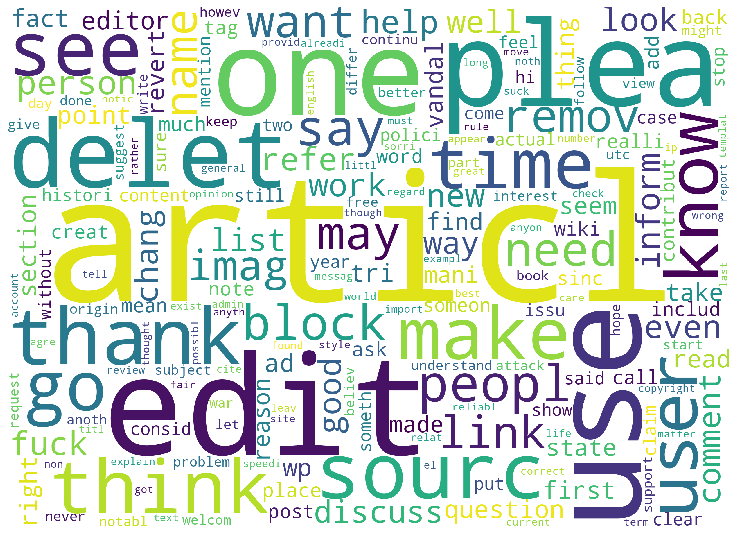

In [6]:
plt.figure(1,figsize=(13, 13))
# clean
text = df_train.comment_text.values
cloud_word = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.imshow(cloud_word)

## Topic Modeling and Latent Dirichlet Allocation (LDA)
- Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents.
- LDA is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model,    modeled as Dirichlet distributions.

In [41]:
print(df_train.columns)
print(df_train.shape)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
(159532, 8)


In [32]:
#word
def get_top_n_words(corpus):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    print('bag shape: ', bag_of_words.shape)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

common_words = get_top_n_words(df_train['comment_text'])
df5 = pd.DataFrame(common_words, columns = ['word' , 'count'])
print(df5)


bag shape:  (159532, 149061)
               word  count
0            articl  74547
1              edit  41613
2             would  36756
3               use  34055
4               one  30815
...             ...    ...
149056         1053      1
149057  hanumakonda      1
149058        956ce      1
149059      automak      1
149060          ciu      1

[149061 rows x 2 columns]


In [43]:
print(df5.describe())

count
count  149061.000000
mean       36.912298
std       494.841540
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max     74547.000000


In [44]:
#unigram
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df_train['comment_text'], 20)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 unigrams in the tweet text"))
fig.update_xaxes(tickangle=45)
fig.show()

In [45]:
#bigram
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_train['comment_text'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the comment text"))
fig.update_xaxes(tickangle=45)
fig.show()

In [46]:
#trigram
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_train['comment_text'], 20)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 trigrams in the comment text"))
fig.update_xaxes(tickangle=45)
fig.show()

## Running LDA model with max feature = 15000
- Decide on the most optimal number of topics 
- perplexity score (lower the better)
- log likelyhood (larger the better)

In [39]:
#input=df_train['comment_text']
#ngram_range=(1,3), max_features=10000
#optimal=12

#tf for LDA model
cv = CountVectorizer(min_df = 3, max_df=0.75, ngram_range=(1,3), max_features=15000) #max_features=15000, 
word_count_vector = cv.fit_transform(df_train['comment_text'])

#finding optimal number of topics for LDA model 
print("Fitting LDA models with %d samples and %d TF features ..."
      % (word_count_vector.shape[0], word_count_vector.shape[1]))
t0 = time()
ids = []
ppls = []
logs = []
for n in [2,3,4,5,6,8,10,12,15,17,19]:
    lda = LDA(n_components=n,               
        max_iter=3,
        learning_offset=10.,    
        learning_method='online', 
        random_state=100,
        batch_size=128,
        n_jobs=-1,
        verbose=1)
    lda.fit(word_count_vector)
    ppl_score = lda.bound_
    ll_score = lda.score(word_count_vector)
    ids.append(n)
    ppls.append(ppl_score)
    logs.append(ll_score)
    
print("Done in %0.3fs." % (time() - t0))

Fitting LDA models with 159532 samples and 15000 TF features ...
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
Done in 364

In [40]:
print(ppl_score)
print(ll_score)

2703.7809953310434
-49139865.87333863


Text(0, 0.5, 'perplexity')

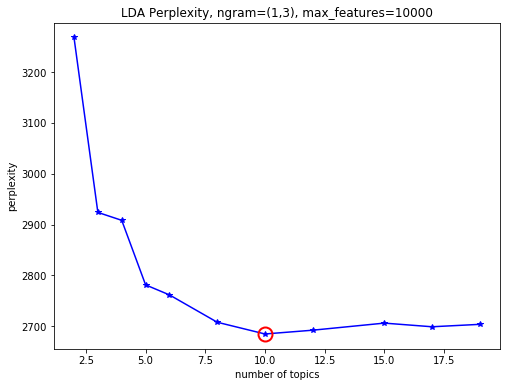

In [41]:
# Plot
kIdx1 = np.argmin(ppls)

fig = plt.figure(figsize=(8, 6))
plt.plot(ids, ppls, 'b*-')
plt.plot(ids[kIdx1], ppls[kIdx1], marker='o', markersize=14, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.title('LDA Perplexity, ngram=(1,3), max_features=10000')
plt.xlabel('number of topics')
plt.ylabel('perplexity')

Text(0, 0.5, 'LogLikelyhood')

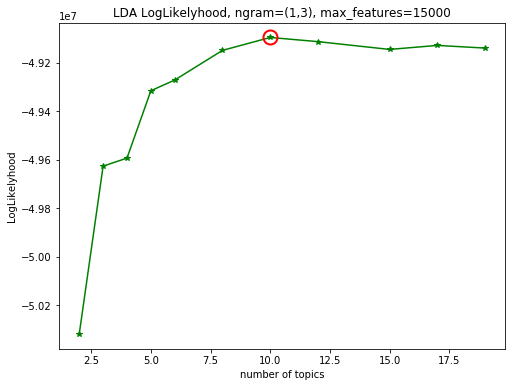

In [42]:
kIdx2 = np.argmax(logs)

fig = plt.figure(figsize=(8, 6))
plt.plot(ids, logs, 'g*-')
plt.plot(ids[kIdx2], logs[kIdx2], marker='o', markersize=14, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.title('LDA LogLikelyhood, ngram=(1,3), max_features=15000')
plt.xlabel('number of topics')
plt.ylabel('LogLikelyhood')
# fig.savefig('lda_LogLikelyhood_max_features=5000.png')

## After optimal number of topics, we display the words

In [44]:
# print top words per topic
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(", ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))  

In [45]:
# Build LDA Model with optimal number of topics = 12

#tf for LDA model
cv = CountVectorizer(min_df =3, max_df=0.75, ngram_range=(1,3), max_features=15000) #max_features=15000, 
word_count_vector = cv.fit_transform(df_train['comment_text'])

print("Fitting LDA models with %d samples and %d TF features ..."
      % (word_count_vector.shape[0], word_count_vector.shape[1]))
t0 = time()

lda_model = LDA(n_components=10,         # Number of topics
              max_iter=10,                # Max learning iterations
              learning_offset=10., 
              learning_method='online',   
              random_state=100,          # Random state
              batch_size=128,            # n docs in each learning iter
              evaluate_every=-1,       # compute perplexity every n iters, default: Don't
              n_jobs=-1,               # Use all available CPUs
              verbose=1)
    
lda_output = lda_model.fit_transform(word_count_vector)
print("Done in %0.3fs." % (time() - t0))

print(lda_model)  # Model attributes

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(word_count_vector))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(word_count_vector))

# Print the topics found by the LDA model
print("Topics found via LDA Model:")
print_topics(model=lda_model, vectorizer=cv, n_top_words=15)

Fitting LDA models with 159532 samples and 15000 TF features ...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Done in 1031.846s.
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=1)
Log Likelihood:  -49028758.79783893
Perplexity:  2655.899854148893
Topics found via LDA Model:

Topic #0:
imag, fuck, use, copyright, fair

In [46]:
# Print the topics found by the LDA model
print("Topics found via LDA Model:")
print_topics(model=lda_model, vectorizer=cv, n_top_words=15)

Topics found via LDA Model:

Topic #0:
imag, fuck, use, copyright, fair, upload, fair use, delet, file, jpg, fuck fuck, fuck fuck fuck, tag, bitch, medium

Topic #1:
would, know, think, like, articl, one, make, time, see, discuss, good, comment, look, want, thing

Topic #2:
name, state, year, world, peopl, also, english, nation, languag, american, countri, call, first, one, respons

Topic #3:
http, com, www, hate, org, jew, http www, lol, nigger, gay, en, lol lol, lol lol lol, theori, anti

Topic #4:
block, user, edit, person, delet, attack, get, wiki, admin, care, stop, like, peopl, guy, shit

Topic #5:
delet, articl, tag, speedi, speedi delet, notabl, pleas, may, criterion, subject, guidelin, note, delet articl, org wiki, oppos

Topic #6:
articl, sourc, use, refer, section, inform, wp, also, remov, need, fact, one, includ, claim, point

Topic #7:
edit, pleas, thank, vandal, user, hi, revert, help, block, ip, messag, continu, use, ban, contribut

Topic #8:
utc, help, question, style, 

In [48]:
def get_lda_topics(model, vectorizer, num_topics, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {}
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic #' + '{:d}'.format(i)] = words
    
    return pd.DataFrame(word_dict)

get_lda_topics(model=lda_model, vectorizer=cv, num_topics=10, n_top_words=15)

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9
0,imag,would,name,http,block,delet,articl,edit,utc,get
1,fuck,know,state,com,user,articl,sourc,pleas,help,day
2,use,think,year,www,edit,tag,use,thank,question,go
3,copyright,like,world,hate,person,speedi,refer,vandal,style,like
4,fair,articl,peopl,org,delet,speedi delet,section,user,welcom,one
5,upload,one,also,jew,attack,notabl,inform,hi,edit,suck
6,fair use,make,english,http www,get,pleas,wp,revert,ask,origin
7,delet,time,nation,lol,wiki,may,also,help,2005,way
8,file,see,languag,nigger,admin,criterion,remov,block,color,peopl
9,jpg,discuss,american,gay,care,subject,need,ip,use,lot
